In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


import json, argparse
from include.utils import DotDic, plot_learning_curve

from Environment import Environment

from include.MADDPG.maddpg import MADDPG
from include.MADDPG.buffer import MultiAgentReplayBuffer

In [9]:
parser = argparse.ArgumentParser()

parser.add_argument("--seed", default=13, type=int)
parser.add_argument("--tau", default=0.01, type=float)  # Target network update rate
parser.add_argument("--gamma", default=0.95, type=float)  # Target network update rate
parser.add_argument('--actor_lr', type=float, default=1e-3)  # learning rate of actor training
parser.add_argument('--critic_lr', type=float, default=2e-2)  # learning rate of critic training
parser.add_argument("--batch_size", default=32, type=int)  # Batch size for both actor and critic
parser.add_argument('--actor_hidden', type=list, default=[512, 256, 128])
parser.add_argument('--critic_hidden', type=list, default=[512, 256, 128])
parser.add_argument('--model_path', type=str, default="./MADDPG Training")  # learning rate

parser.add_argument('-c1', '--config_scenario', default='./configs/scenario.json', type=str, help='path to existing scenarionarios file')
args = parser.parse_args(args=[])

if not os.path.exists('%s/' % (args.model_path)):
  os.makedirs('%s/' % (args.model_path))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
scenario = DotDic(json.loads(open(args.config_scenario, 'r').read()))

In [10]:
# Environment action and states
K = scenario.K_t + scenario.K_r
L = scenario.L_t + scenario.L_r

# Actions: (Re{w_k}, Im{w_k}), (Re{u_l}, Im{u_l}), (theta_r, theta_t), rho_l
action_size =   (2 * K * scenario.Nt) + \
                (2 * L * scenario.Nt) + \
                (2 * scenario.R * scenario.Mr) + L

# States:  h, g, h_s, g_s, H, f, STR
state_size =    (scenario.Nt * K) + (scenario.Nt * L) + \
                (scenario.Mr * scenario.R * K) + \
                (scenario.Mr * scenario.R * L) + \
                (scenario.Mr * scenario.Nt * scenario.R) + \
                (L * K) + 1

max_action = 1

print(f'Action space size is: {action_size}, \nState space size is: {state_size}.')

Action space size is: 131, 
State space size is: 434.


In [11]:
def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

In [12]:
n_agents = 3

# create the environment
env = Environment(scenario, state_size, action_size)
env_test = Environment(scenario, state_size, action_size)

actor_dims = [state_size] * n_agents
critic_dims = sum(actor_dims)
n_actions = action_size

# Create a DDPG instance
agents = MADDPG(actor_dims, critic_dims, n_agents, n_actions, fc1=64, fc2=64, alpha=0.01, beta=0.01, scenario='',chkpt_dir=args.model_path)
agent_test = MADDPG(actor_dims, critic_dims, n_agents, n_actions, fc1=64, fc2=64, alpha=0.01, beta=0.01, scenario='',chkpt_dir=args.model_path)

memory = MultiAgentReplayBuffer(100000, critic_dims, actor_dims, n_actions, n_agents, batch_size=1024)

## Train

In [13]:
ep_r = 0
score_hist = []

max_episode = 200
max_steps = 500
trainig_iteration = 32

# Train the agent for max_episodes
for e in range(max_episode):
    done = [False]*n_agents
    total_reward = 0
    obs = []
    for agent_id in range(n_agents):
        state = env.reset()
        obs.append(state)

    print(f'Training: \n\t episode {e+1}/{max_episode} ...')
    for t in range(max_steps):

        actions = agents.choose_action(obs)

        obs_ = []
        rewards = []
        dones = []
        for agent_id in range(n_agents):
            phi_r, phi_t, rho, w, u = env.action_cal(actions[agent_id])
            next_state, reward, done, info = env.step(phi_r, phi_t, rho, w, u)
            obs_.append(next_state)
            rewards.append(reward)
            dones.append(done)

        state = obs_list_to_state_vector(obs)
        state_ = obs_list_to_state_vector(obs_)

        if t >= max_steps-1:
            done = [True]*n_agents
        
        memory.store_transition(obs, state, actions, rewards, obs_, state_, dones)

        if e % 10 == 0:
            agents.learn(memory)

        obs = obs_
        total_reward += sum(rewards)

        if sum(dones) == n_agents:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
    score_hist.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))
    
    
    if e % 100 == 0:
        agents.save_checkpoint()

Training: 
	 episode 1/200 ...


	 Not done !
	 Total Reward: -16408645701.06 
... saving checkpoint ...
Training: 
	 episode 2/200 ...
	 Not done !
	 Total Reward: -13419917070.94 
Training: 
	 episode 3/200 ...
	 Not done !
	 Total Reward: -17109671520.25 
Training: 
	 episode 4/200 ...
	 Not done !
	 Total Reward: -14237178502.40 
Training: 
	 episode 5/200 ...
	 done in step 85
	 Total Reward: -1968540829.20 
Training: 
	 episode 6/200 ...
	 done in step 38
	 Total Reward: -1046099365.52 
Training: 
	 episode 7/200 ...
	 Not done !
	 Total Reward: -15575845812.25 
Training: 
	 episode 8/200 ...
	 done in step 106
	 Total Reward: -2528338035.88 
Training: 
	 episode 9/200 ...
	 Not done !
	 Total Reward: -15612128736.22 
Training: 
	 episode 10/200 ...
	 Not done !
	 Total Reward: -14332762919.59 
Training: 
	 episode 11/200 ...
	 Not done !
	 Total Reward: -13353880642.73 
Training: 
	 episode 12/200 ...
	 done in step 19
	 Total Reward: -441639075.71 
Training: 
	 episode 13/200 ...
	 done in step 244
	 Total Rew

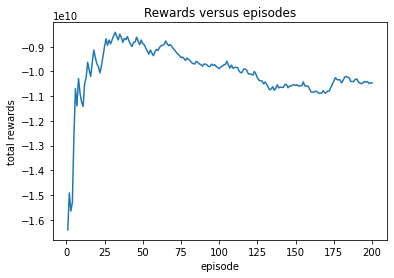

In [14]:
plot_learning_curve(score_hist)

## Test

In [18]:
test_episode = 100
max_steps = 300
score_hist_test = []
agent_test.load_checkpoint()

for e in range(test_episode):
    done = 0
    total_reward = 0
    state = env_test.reset()
    
    print(f'Testing: \n\t episode {e+1}/{test_episode} ...')
    for t in range(max_steps):


        actions = agents.choose_action(obs)

        obs_ = []
        rewards = []
        dones = []
        for agent_id in range(n_agents):
            phi_r, phi_t, rho, w, u = env.action_cal(actions[agent_id])
            next_state, reward, done, info = env.step(phi_r, phi_t, rho, w, u)
            obs_.append(next_state)
            rewards.append(reward)
            dones.append(done)

        state = obs_list_to_state_vector(obs)
        state_ = obs_list_to_state_vector(obs_)

        if t >= max_steps-1:
            done = [True]*n_agents

        obs = obs_
        total_reward += sum(rewards)

        if done:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
    score_hist_test.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))

... loading checkpoint ...
Testing: 
	 episode 1/100 ...
	 done in step 4
	 Total Reward: -117308419.95 
Testing: 
	 episode 2/100 ...
	 done in step 13
	 Total Reward: -416964641.40 
Testing: 
	 episode 3/100 ...
	 done in step 2
	 Total Reward: -48037731.33 
Testing: 
	 episode 4/100 ...
	 done in step 4
	 Total Reward: -111359811.22 
Testing: 
	 episode 5/100 ...
	 done in step 13
	 Total Reward: -412774617.72 
Testing: 
	 episode 6/100 ...
	 done in step 6
	 Total Reward: -179663805.88 
Testing: 
	 episode 7/100 ...
	 done in step 1
	 Total Reward: -14718917.17 
Testing: 
	 episode 8/100 ...
	 done in step 1
	 Total Reward: -17182142.40 
Testing: 
	 episode 9/100 ...
	 done in step 1
	 Total Reward: -16357957.49 
Testing: 
	 episode 10/100 ...
	 done in step 10
	 Total Reward: -316630405.40 
Testing: 
	 episode 11/100 ...
	 done in step 2
	 Total Reward: -49761521.06 
Testing: 
	 episode 12/100 ...
	 done in step 11
	 Total Reward: -348018231.73 
Testing: 
	 episode 13/100 ...
	 do

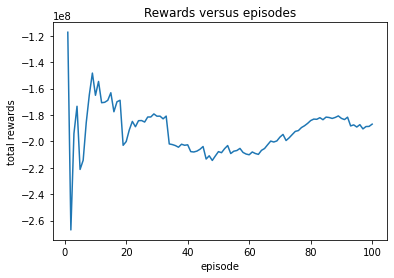

In [19]:
plot_learning_curve(score_hist_test)